In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [52]:
!pip install astroML


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [53]:
from astroML.datasets import fetch_rrlyrae_mags

data = fetch_rrlyrae_mags()
# number of objects in dataset

data = data.byteswap().newbyteorder()

df = pd.DataFrame(data)
df.head()

,__SIG2010_,Type,Per,uAmp,T0_u,gAmp,T0_g,rAmp,T0_r,iAmp,...,RAJ2000,DEJ2000,Ar,Dist,umag,gmag,rmag,imag,zmag,Vmag
0,4099,b'ab',0.641754,0.534608,51075.274714,0.563839,51075.288902,0.398326,51075.295112,0.317851,...,0.935679,1.115859,0.089,17.750000,18.134001,16.989000,16.777000,16.702999,16.684999,16.846001
1,13350,b'ab',0.547987,1.029445,54025.330112,1.093322,54025.326856,0.801720,54025.326474,0.642111,...,0.283437,1.178522,0.080,24.770000,18.839001,17.679001,17.544001,17.497000,17.500999,17.570000
2,15927,b'ab',0.612263,0.651579,53680.222485,0.697439,53680.229439,0.486554,53680.226214,0.368674,...,3.254658,-0.584066,0.090,29.120001,19.288000,18.058001,17.858999,17.792000,17.780001,17.921000
3,20406,b'ab',0.631853,0.553247,54000.280528,0.586784,54000.292109,0.426846,54000.276631,0.342734,...,3.244369,0.218891,0.088,9.130000,16.715000,15.543000,15.336000,15.286000,15.276000,15.403000
4,21992,b'ab',0.625880,1.109322,53698.245218,1.139930,53698.245256,0.849551,53698.243534,0.661144,...,4.315354,1.054582,0.077,7.350000,16.186001,15.040000,14.909000,14.864000,14.853000,14.932000


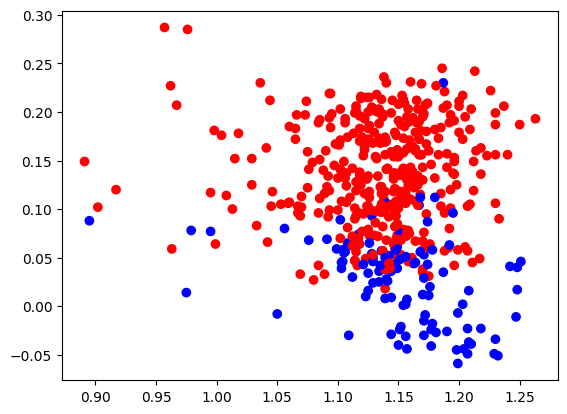

In [54]:
df['u-g'] = df['umag'] - df['gmag']
df['g-r'] = df['gmag'] - df['rmag']
df['r-i'] = df['rmag'] - df['imag']
df['i-z'] = df['imag'] - df['zmag']

plt.scatter(df['u-g'], df['g-r'], c=np.where(df['Type'] == b'ab', 'r', 'b'))

In [55]:
def phi(A, u):
    return sum(u[i]*np.dot(A[i].T, A[i])for i in range(len(u))) - np.dot(sum(u[i]*A[i] for i in range(len(u))).T,sum(u[i]*A[i] for i in range(len(u))))

<img src="./away_step_pseudocode.png" alt="Alternative text" />

In [56]:
def LMO(gradient):
    lmo = np.argmin(gradient)
    return lmo

In [57]:
def vertex_computation(set_weights, gradient, dimension_m):
    weight_indexes = np.where(set_weights > 0)[0]
    max_gradient_index = np.argmax(gradient[weight_indexes])
    v_index = weight_indexes[max_gradient_index]
    v = np.zeros(dimension_m)
    v[v_index] = 1.0
    return v, v_index

In [168]:
def armijo_method(A, u, alpha = 0.9, delta = 0.5, gamma = 0.1,  max_iter=100):   
    gradient = np.matmul(2 * np.matmul(A, A.T), u) - np.sum(np.square(A), axis=1)
    gradient_norm = np.linalg.norm(gradient)
    f_u = -phi(A, u)
    for i in range(max_iter):
        
        new_u = u - alpha * gradient
        f_new_u = -phi(A, new_u)

        # Armijo condition
        if f_new_u <= f_u - gamma * alpha * gradient_norm ** 2:
            return alpha
        # Reduce step size
        alpha *= delta
    return alpha

In [152]:
# 
def frankWolfe_AwayStep(A, epsilon, max_iterations=1000, step_size = "Harmonic"):
    
    total_time = 0
    count_FrankWolfe = 0
    count_AwayStep = 0
    count_dropped = 0 
    count_iterations = 0
    dual_val_list = []
    dual_gap_list = []

    m, n = A.shape

    # initialize u vector
    u = np.zeros(m)
    u[0] = 1.0

    # Create set S containing the u values across time
    S_set = np.zeros(m)
    S_set[np.where(u > 0)[0]] = 1

    for i in range(max_iterations):
        time_start = time.time()

        count_iterations += 1

        dual_val = -phi(A, u) # We minimize the negative objective function
        dual_val_list.append(dual_val) # Keep track of the changes in the objective function across iterations

        gradient = np.matmul(2 * np.matmul(A, A.T), u) - np.sum(np.square(A), axis=1) # Gradient computation
        
        # FW direction
        s_index= LMO(gradient) 
        s = np.zeros(m)
        s[s_index] = 1.0
        direction_FrankWolfe = s - u
        
        # AW direction
        v, v_index = vertex_computation(S_set, gradient, m)
        direction_AwayStep = u - v

        # Stopping criterion
        gap_FrankWolfe = -gradient.T @ direction_FrankWolfe 
        dual_gap_list.append(gap_FrankWolfe) 
        if gap_FrankWolfe <= epsilon:
            comp_time = time.time() - time_start
            total_time = comp_time + total_time
            # CPU_time_list.append(total_time)
            # active_set_size_list.append(int(np.sum(np.abs(S_t) >= 0.0001))) # Used to track the active set size over time for plotting purposes
            break

        # Compare and choose between FW and AS 
        gap_AwayStep = -gradient.T @ direction_AwayStep 
        if gap_FrankWolfe >= gap_AwayStep:
            # Frank-Wolfe 
            direction_chosen = direction_FrankWolfe
            max_alpha = 1  # Max step-size FW
            frankwolfe_flag = True
        else:
            # Away-step
            direction_chosen = direction_AwayStep
            max_alpha = S_set[v_index] / (1 - S_set[v_index]) # Max step-size AS
            frankwolfe_flag = False

        # alpha = calculate_step_size(line_search_strategy, i, A_squared, u, Z, direction_chosen, gradient, max_alpha)
        # Step-size
        if step_size == "Harmonic":
            alpha = 2 / (i + 1) 
        elif step_size == "Armijo":
            alpha = armijo_method(A, u)
        alpha = max(0.0, min(alpha, max_alpha))

        # update u
        u = u + (alpha * direction_chosen)

        # Update set S
        if frankwolfe_flag: # FW step
            S_set = (1 - alpha) * S_set # alpha_v update
            S_set[s_index] = S_set[s_index] + alpha # alpha_S_t update
            if alpha > 0.999999: # step-size is max
                # Set S = {s_t}
                S_set = np.zeros(m)
                S_set[s_index] = 1 
            count_FrankWolfe += 1 
        else: # AS step
            S_set = (1 + alpha) * S_set # alpha_v update
            count_AwayStep += 1
            if abs(alpha - max_alpha) < 0.000001: # step-size is max
                count_dropped += 1
                S_set[v_index] = 0 # drop step
            else:
                S_set[v_index] = S_set[v_index] - alpha # alpha_V_t update
        # active_set_size_list.append(int(np.sum(np.abs(S_t) > 0))) # Used to track the active set size over time for plotting purposes\
        
        iteration_time = time.time() - time_start
        total_time = total_time + iteration_time
        # CPU_time_list.append(total_time) # Used to track the total time over time for plotting purposes REMOVE LATER??

    radius = np.sqrt(-dual_val)
    center = np.matmul(A.T, u)

    return center, radius, count_iterations, total_time, dual_val_list, dual_gap_list

In [176]:
# 
def frankWolfe_Pairwise(A, epsilon, max_iterations=1000, step_size = "Harmonic"):
    
    total_time = 0
    count_iterations = 0
    dual_val_list = []
    dual_gap_list = []
    
    m, n = A.shape

    # initialize u vector
    u = np.zeros(m)
    u[0] = 1.0

    # Create set S containing the u values across time
    S_set = np.zeros(m)
    S_set[np.where(u > 0)[0]] = 1

    for i in range(max_iterations):
        time_start = time.time()
        count_iterations += 1

        dual_val = -phi(A, u) # We minimize the negative objective function
        dual_val_list.append(dual_val) # Keep track of the changes in the objective function across iterations
        
        gradient = np.matmul(2 * np.matmul(A, A.T), u) - np.sum(np.square(A), axis=1) # Gradient computation
        
        # Compute the Pairwise direction
        s_index= LMO(gradient)
        s = np.zeros(m)
        s[s_index] = 1.0
        v, v_index = vertex_computation(S_set, gradient, m)
        direction_Pairwise = s - v

        # Stopping criterion
        gap_FrankWolfe = -gradient.T @ direction_Pairwise
        dual_gap_list.append(gap_FrankWolfe) 
        if gap_FrankWolfe <= epsilon:
            comp_time = time.time() - time_start
            total_time = comp_time + total_time
            # CPU_time_list.append(total_time)
            # active_set_size_list.append(int(np.sum(np.abs(S_t) >= 0.0001))) # Used to track the active set size over time for plotting purposes
            break

        # Step-size
        if step_size == "Harmonic":
            alpha = 2 / (i + 1)
        elif step_size == "Armijo":
            alpha = armijo_method(A, u)
        alpha = min(alpha, S_set[v_index])

        # update u
        u = u + (alpha * direction_Pairwise)

        # Update set S
        S_set[v_index] = S_set[v_index] - alpha # alpha_V_t update
        S_set[s_index] = S_set[s_index] + alpha # alpha_S_t update

        iteration_time = time.time() - time_start
        total_time = total_time + iteration_time
        # CPU_time_list.append(total_time) # Used to track the total time over time for plotting purposes REMOVE LATER??

    radius = np.sqrt(-dual_val)
    center = np.matmul(A.T, u)
    
    return center, radius, count_iterations, total_time, dual_val_list, dual_gap_list

In [153]:
# we supply: A, epsilon, max_iterations=1000
A = df[df['Type']==b'ab'][['u-g', 'g-r']].values
epsilon = 0.001

center_AS, radius_AS, count_iterations_AS, total_time_AS, dual_val_list_AS, dual_gap_list_AS = frankWolfe_AwayStep(A, epsilon, max_iterations=1000, step_size="Armijo")

print("CENTER: ", center_AS)
print("RADIUS: ", radius_AS)
print("COUNT ITERATIONS: ", count_iterations_AS)
print("TOTAL TIME: ", total_time_AS)

CENTER:  [1.07943672 0.14826954]
RADIUS:  0.18628785886802166
COUNT ITERATIONS:  967
TOTAL TIME:  27.080861568450928


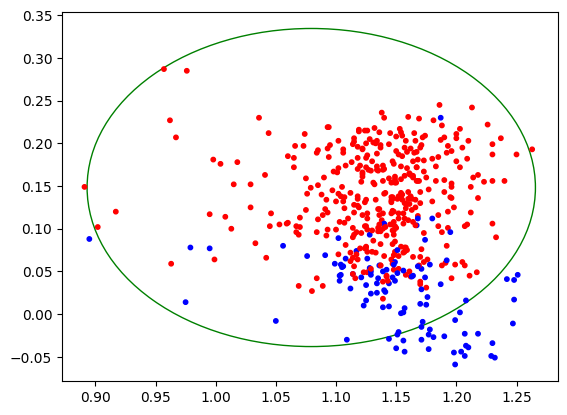

In [154]:
circle = plt.Circle(tuple(center_AS), radius_AS, color='g', fill=False)

ax = plt.gca()
ax.cla()
ax.add_patch(circle)

plt.scatter(df['u-g'], df['g-r'], c=np.where(df['Type'] == b'ab', 'r', 'b'), s=10)

In [177]:
# we supply: A, epsilon, max_iterations=1000
A = df[df['Type']==b'ab'][['u-g', 'g-r']].values
epsilon = 0.001

center_PFW, radius_PFW, count_iterations_PFW, total_time_PFW, dual_val_list_PFW, dual_gap_list_PFW= frankWolfe_Pairwise(A, epsilon, max_iterations=1000, step_size = "Armijo")

print("CENTER: ", center_PFW)
print("RADIUS: ", radius_PFW)
print("COUNT ITERATIONS: ", count_iterations_PFW)
print("TOTAL TIME: ", total_time_PFW)


CENTER:  [1.07914927 0.15766886]
RADIUS:  0.18703930821855655
COUNT ITERATIONS:  620
TOTAL TIME:  17.371903896331787


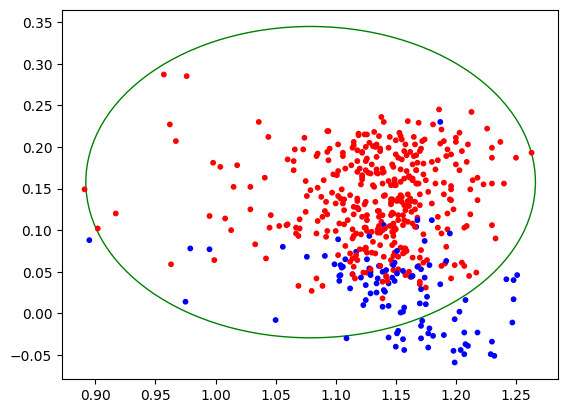

In [178]:
circle = plt.Circle(tuple(center_PFW), radius_PFW, color='g', fill=False)

ax = plt.gca()
ax.cla()
ax.add_patch(circle)

plt.scatter(df['u-g'], df['g-r'], c=np.where(df['Type'] == b'ab', 'r', 'b'), s=10)

Using the Full Dataset

In [143]:
Full_dataset = df[df['Type'] == b'ab'].drop('Type', axis=1).values

Standardized Full Dataset

In [144]:
# Standardize the dataset
Full_dataset_mean = np.mean(Full_dataset, axis=0)
Full_dataset_std = np.std(Full_dataset, axis=0)

Standardized_full_dataset = (Full_dataset - Full_dataset_mean) / Full_dataset_std

Awaystep Full Dataset Harmonic

In [ ]:
epsilon = 0.001

center_AS_fdh, radius_AS_fdh, count_iterations_AS_fdh, total_time_AS_fdh, dual_val_list_AS_fdh, dual_gap_list_AS_fdh = frankWolfe_AwayStep(Full_dataset, epsilon, max_iterations=10000, step_size="Harmonic")

print("CENTER: ", center_AS_fdh)
print("RADIUS: ", radius_AS_fdh)
print("COUNT ITERATIONS: ", count_iterations_AS_fdh)
print("TOTAL TIME: ", total_time_AS_fdh)

In [ ]:
plt.plot(dual_val_list_AS_fdh)
plt.title('Dual Away Step Full Dataset Harmonic')
plt.xlabel('Iterations')
plt.ylabel('Function value')

In [ ]:
plt.plot(dual_gap_list_AS_fdh)
plt.title('Dual Gap Away Step Full Dataset Harmonic')
plt.xlabel('Iterations')
plt.ylabel('Gap value')

Awaystep Standardized Full Dataset Harmonic

In [ ]:
epsilon = 0.001

center_AS_sdh, radius_AS_sdh, count_iterations_AS_sdh, total_time_AS_sdh, dual_val_list_AS_sdh, dual_gap_list_AS_sdh = frankWolfe_AwayStep(Standardized_full_dataset, epsilon, max_iterations=10000, step_size="Harmonic")

print("CENTER: ", center_AS_sdh)
print("RADIUS: ", radius_AS_sdh)
print("COUNT ITERATIONS: ", count_iterations_AS_sdh)
print("TOTAL TIME: ", total_time_AS_sdh)

In [ ]:
plt.plot(dual_val_list_AS_sdh)
plt.title('Dual Away Step Standardized Dataset Harmonic')
plt.xlabel('Iterations')
plt.ylabel('Function value')

In [ ]:
plt.plot(dual_gap_list_AS_sdh)
plt.title('Dual Gap Away Step Standardized Dataset Harmonic')
plt.xlabel('Iterations')
plt.ylabel('Gap value')

Awaystep Full Dataset Armijo

In [166]:
epsilon = 0.001

center_AS_fda, radius_AS_fda, count_iterations_AS_fda, total_time_AS_fda, dual_val_list_AS_fda, dual_gap_list_AS_fda = frankWolfe_AwayStep(Full_dataset, epsilon, max_iterations=10000, step_size="Armijo")

print("CENTER: ", center_AS_fda)
print("RADIUS: ", radius_AS_fda)
print("COUNT ITERATIONS: ", count_iterations_AS_fda)
print("TOTAL TIME: ", total_time_AS_fda)

CENTER:  [4.09900002e+03 6.41754000e-01 5.34608251e-01 5.10752747e+04
 5.63838731e-01 5.10752889e+04 3.98325832e-01 5.10752951e+04
 3.17851245e-01 5.10752951e+04 5.10752882e+04 9.35678889e-01
 1.11585889e+00 8.90000016e-02 1.77500000e+01 1.81340008e+01
 1.69890003e+01 1.67770004e+01 1.67029991e+01 1.66849995e+01
 1.68460007e+01 1.14500046e+00 2.11999893e-01 7.40013123e-02
 1.79996490e-02]
RADIUS:  9.972449115614749
COUNT ITERATIONS:  10000
TOTAL TIME:  1418.8570771217346


In [ ]:
plt.plot(dual_val_list_AS_fda)
plt.title('Dual Away Step Full Dataset Armijo')
plt.xlabel('Iterations')
plt.ylabel('Function value')

In [ ]:
plt.plot(dual_gap_list_AS_fda)
plt.title('Dual Gap Away Step Full Dataset Armijo')
plt.xlabel('Iterations')
plt.ylabel('Gap value')

Awaystep Standardized Dataset Armijo

In [167]:
epsilon = 0.001

center_AS_sda, radius_AS_sda, count_iterations_AS_sda, total_time_AS_sda, dual_val_list_AS_sda, dual_gap_list_AS_sda = frankWolfe_AwayStep(Standardized_full_dataset, epsilon, max_iterations=10000, step_size="Armijo")

print("CENTER: ", center_AS_sda)
print("RADIUS: ", radius_AS_sda)
print("COUNT ITERATIONS: ", count_iterations_AS_sda)
print("TOTAL TIME: ", total_time_AS_sda)

CENTER:  [-0.17204213 -0.50586881 -0.19444982 -1.02984001  0.15574911 -1.02981054
  0.31758308 -1.02980044  0.58305477 -1.02981696 -1.02976307 -0.614599
  0.24790679  0.29102435  1.45783288  0.06788772  0.1061719   0.08478841
  0.10195155  0.0566454   0.09577424 -1.19382537  0.66881251 -0.96208156
  2.41393479]
RADIUS:  9.221514540246474
COUNT ITERATIONS:  3918
TOTAL TIME:  159.638991355896


Text(0, 0.5, 'Function value')

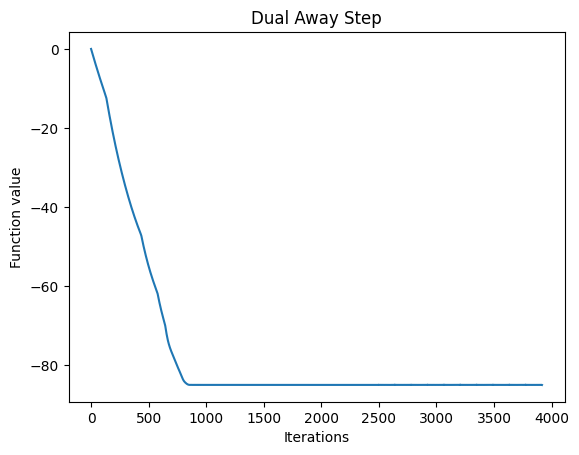

In [170]:
plt.plot(dual_val_list_AS_sda)
plt.title('Dual Away Step Standardized Dataset Armijo')
plt.xlabel('Iterations')
plt.ylabel('Function value')

Text(0, 0.5, 'Function value')

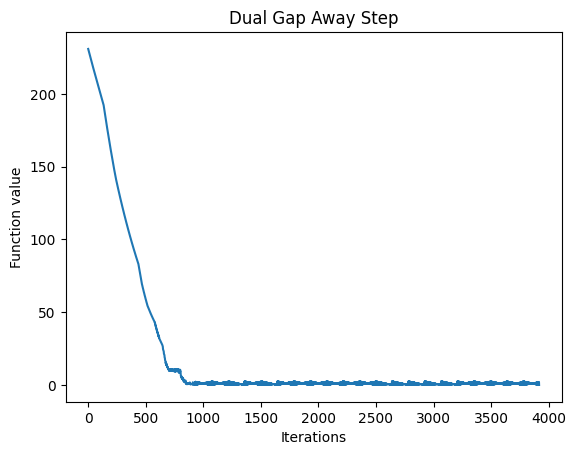

In [171]:
plt.plot(dual_gap_list_AS_sda)
plt.title('Dual Gap Away Step Standardized Dataset Armijo')
plt.xlabel('Iterations')
plt.ylabel('Gap value')

Pairwise Full Dataset Harmonic

In [ ]:
epsilon = 0.001

center_PFW_fdh, radius_PFW_fdh, count_iterations_PFW_fdh, total_time_PFW_fdh, dual_val_list_PFW_fdh, dual_gap_list_PFW_fdh = frankWolfe_Pairwise(Full_dataset, epsilon, max_iterations=10000, step_size  = "Harmonic")

print("CENTER: ", center_PFW_fdh)
print("RADIUS: ", radius_PFW_fdh)
print("COUNT ITERATIONS: ", count_iterations_PFW_fdh)
print("TOTAL TIME: ", total_time_PFW_fdh)

In [ ]:
plt.plot(dual_val_list_PFW_fdh)
plt.title('Dual Pairwise Full Dataset Harmonic')
plt.xlabel('Iterations')
plt.ylabel('Function value')

In [ ]:
plt.plot(dual_gap_list_PFW_fdh)
plt.title('Dual Gap Pairwise Full Dataset Harmonic')
plt.xlabel('Iterations')
plt.ylabel('Gap value')

Pairwise Standardized Full Dataset Harmonic

In [ ]:
epsilon = 0.001

center_PFW_sdh, radius_PFW_sdh, count_iterations_PFW_sdh, total_time_PFW_sdh, dual_val_list_PFW_sdh, dual_gap_list_PFW_sdh = frankWolfe_Pairwise(Standardized_full_dataset, epsilon, max_iterations=10000, step_size  = "Harmonic")

print("CENTER: ", center_PFW_sdh)
print("RADIUS: ", radius_PFW_sdh)
print("COUNT ITERATIONS: ", count_iterations_PFW_sdh)
print("TOTAL TIME: ", total_time_PFW_sdh)

In [ ]:
plt.plot(dual_val_list_PFW_sdh)
plt.title('Dual Pairwise Standardized Dataset Harmonic')
plt.xlabel('Iterations')
plt.ylabel('Function value')

In [ ]:
plt.plot(dual_gap_list_PFW_sdh)
plt.title('Dual Gap Pairwise Standardized Dataset Harmonic')
plt.xlabel('Iterations')
plt.ylabel('Gap value')

Pairwise Full Dataset Armijo

In [179]:
epsilon = 0.001

center_PFW_fda, radius_PFW_fda, count_iterations_PFW_fda, total_time_PFW_fda, dual_val_list_PFW_fda, dual_gap_list_PFW_fda = frankWolfe_Pairwise(Full_dataset, epsilon, max_iterations=10000, step_size  = "Armijo")

print("CENTER: ", center_PFW_fda)
print("RADIUS: ", radius_PFW_fda)
print("COUNT ITERATIONS: ", count_iterations_PFW_fda)
print("TOTAL TIME: ", total_time_PFW_fda)

CENTER:  [4.09900002e+03 6.41754000e-01 5.34608251e-01 5.10752747e+04
 5.63838731e-01 5.10752889e+04 3.98325832e-01 5.10752951e+04
 3.17851245e-01 5.10752951e+04 5.10752882e+04 9.35678889e-01
 1.11585889e+00 8.90000016e-02 1.77500000e+01 1.81340008e+01
 1.69890003e+01 1.67770004e+01 1.67029991e+01 1.66849995e+01
 1.68460007e+01 1.14500046e+00 2.11999893e-01 7.40013123e-02
 1.79996490e-02]
RADIUS:  9.972449115614749
COUNT ITERATIONS:  10000
TOTAL TIME:  1240.8017964363098


In [ ]:
plt.plot(dual_val_list_PFW_fda)
plt.title('Dual Pairwise Full Dataset Armijo')
plt.xlabel('Iterations')
plt.ylabel('Function value')

In [ ]:
plt.plot(dual_gap_list_PFW_fda)
plt.title('Dual Pairwise Full Dataset Armijo')
plt.xlabel('Iterations')
plt.ylabel('Gap value')

Pairwise Standardized Dataset Armijo

In [180]:
epsilon = 0.001

center_PFW_sda, radius_PFW_sda, count_iterations_PFW_sda, total_time_PFW_sda, dual_val_list_PFW_sda, dual_gap_list_PFW_sda = frankWolfe_Pairwise(Standardized_full_dataset, epsilon, max_iterations=10000, step_size  = "Armijo")

print("CENTER: ", center_PFW_sda)
print("RADIUS: ", radius_PFW_sda)
print("COUNT ITERATIONS: ", count_iterations_PFW_sda)
print("TOTAL TIME: ", total_time_PFW_sda)

CENTER:  [-0.19714155 -0.47527876 -0.1850823  -1.02543335  0.16119669 -1.02540426
  0.32403166 -1.02539409  0.59637895 -1.02541056 -1.02535664 -0.60100828
  0.20963563  0.21730529  1.43218787  0.02814182  0.0663192   0.04500618
  0.06222042  0.01672205  0.0559675  -1.17096162  0.65956469 -0.97160496
  2.40582564]
RADIUS:  9.219375721064567
COUNT ITERATIONS:  10000
TOTAL TIME:  227.29772400856018


Text(0, 0.5, 'Function value')

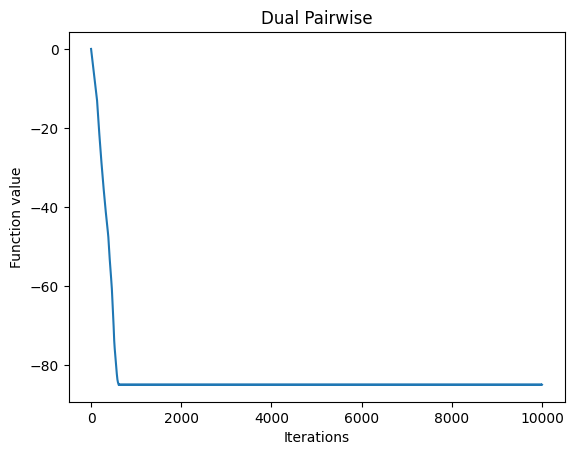

In [181]:
plt.plot(dual_val_list_PFW_sda)
plt.title('Dual Pairwise Standardized Dataset Armijo')
plt.xlabel('Iterations')
plt.ylabel('Function value')

In [184]:
plt.plot(dual_gap_list_PFW_sda)
plt.title('Dual Gap Pairwise Standardized Dataset Armijo')
plt.xlabel('Iterations')
plt.ylabel('Gap value')

NameError: name 'dual_gap_list_PFW_sda' is not defined